## Nea ancestry vs distance to selected regions

In [1]:
suppressPackageStartupMessages({

library(slimr)
library(tidyverse)
library(GenomicRanges)

})

In [2]:
gens <- c(10, 20, 50, 100, seq(200, 1000, 200), seq(1200, 2200, 200))

In [3]:
n_bins <- 5

# Testing different regions / different amounts of deleterious sequence

In [4]:
region_names <- c("exon", "promoter", "tf_binding_site", "protein_coding", "utr3")

In [5]:
region_sizes <- data.frame(
    region = region_names,
    size = map_int(region_names, ~ sum(width(read_coordinates(paste0("../data/slim_coords/", .x, "_regions.bed")))))
) %>% arrange(size)

In [6]:
region_sizes

region,size
tf_binding_site,10420529
promoter,22626395
protein_coding,33741600
utr3,37392361
exon,73764022


In [7]:
raw_bin_props <- map_dfr(region_names, function(region) {

# load the table of coordinates (real and SLiM-based) of functional regions
regions <- read_coordinates(paste0("../data/slim_coords/", region, "_regions.bed"))
trans_regions <- transpose_coordinates(regions, regions)

# load the table of coordinates (real and SLiM-based) of fixed markers (both within and outside selected regions)
all_sites <- read_coordinates(paste0("../data/slim_coords/", region, "_all_sites.bed"))

binned_chroms <- mclapply(1:20, mc.cores = 20, function(rep) {
    
map_dfr(gens, function(gen) {

    vcf <- read_vcf(paste0("../data/simulations/delta_constant_", region, "_h_0.5_rep_", rep, "_gen_", gen, ".vcf.gz"))

    trans_markers <- mut_gt(vcf, mut_type = 1) %>% fill_lost(all_sites) %>% transpose_coordinates(all_sites)

    inside_markers  <- trans_markers[trans_markers %within% trans_regions]
    outside_markers <- trans_markers[! trans_markers %within% trans_regions]

    hap_ids <- colnames(mcols(inside_markers)) %>% keep(~ str_detect(.x, "chr"))

    distance_hits <- distanceToNearest(outside_markers, trans_regions, ignore.strand = TRUE)
    qs <- quantile(mcols(distance_hits)$distance, probs = seq(0, 1, 1 / n_bins))

    outside_dist <- mcols(outside_markers) %>%
        as.data.frame %>%
        mutate(distance = mcols(distance_hits)$distance,
               dist_bin = as.integer(cut(distance, breaks = qs, labels = 1:n_bins, include.lowest = TRUE))) %>%
        mutate(rep = rep, gen = gen) %>%
        select(rep, gen, freq, dist_bin, starts_with("chr"))

    inside_dist <- mcols(inside_markers) %>%
        as.data.frame %>%
        mutate(dist_bin = 0) %>%
        mutate(rep = rep, gen = gen) %>%
        select(rep, gen, freq, dist_bin, starts_with("chr"))
    
    bind_rows(outside_dist, inside_dist)

})

}) %>% bind_rows

group_by(binned_chroms, dist_bin, gen) %>%
    summarise_at(vars(starts_with("chr")), mean) %>%
    gather(chr, nea_prop, -dist_bin, -gen) %>%
    ungroup %>% 
    mutate(dist_bin = factor(dist_bin),
           region = region)

})

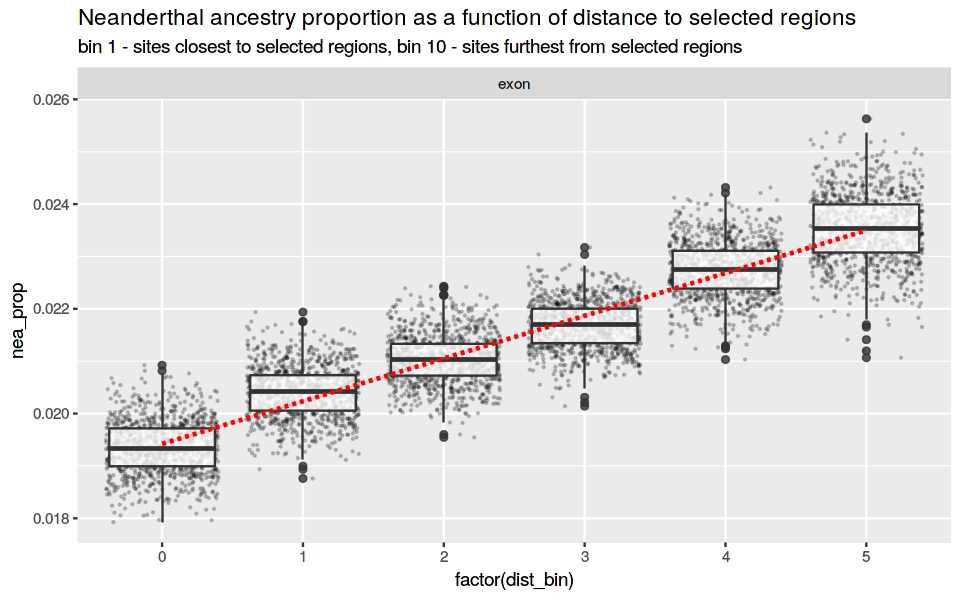

In [13]:
options(repr.plot.width = 8, repr.plot.height = 5)

raw_bin_props %>%
    filter(gen == 2200, region == "exon") %>%
    ggplot(aes(factor(dist_bin), nea_prop)) +
        geom_jitter(alpha = 1/5, size = 0.2) +
        geom_boxplot(alpha = 0.8) +
        geom_smooth(aes(group = 1), method = "lm", linetype = 2, color = "red") +
        facet_wrap(~ region) +
        ggtitle("Neanderthal ancestry proportion as a function of distance to selected regions",
                "bin 1 - sites closest to selected regions, bin 10 - sites furthest from selected regions")

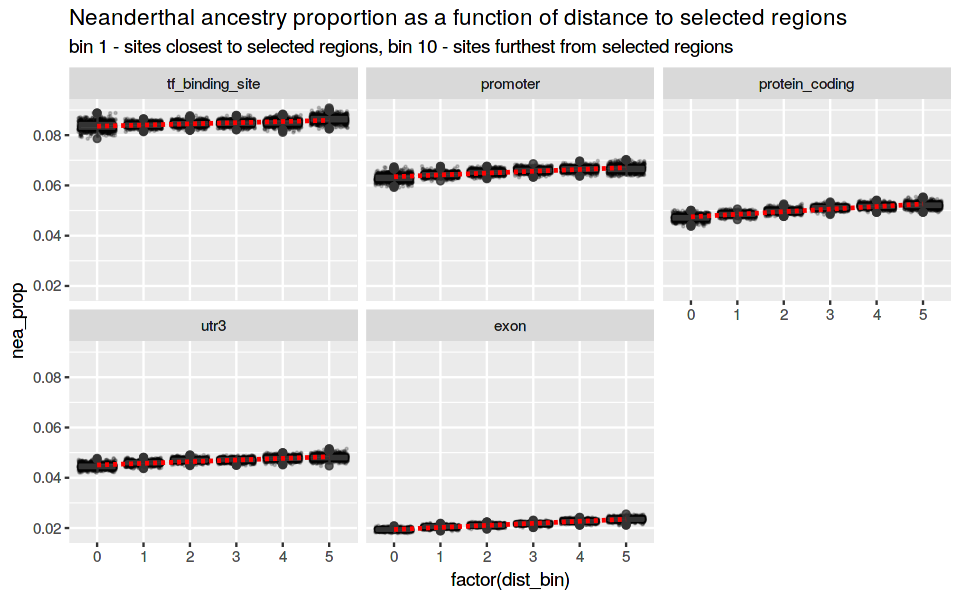

In [9]:
options(repr.plot.width = 8, repr.plot.height = 5)

raw_bin_props %>%
    filter(gen == 2200) %>%
    mutate(region = factor(region, levels = region_sizes$region)) %>% 
    ggplot(aes(factor(dist_bin), nea_prop)) +
        geom_jitter(alpha = 1/5, size = 0.2) +
        geom_boxplot(alpha = 0.8) +
        geom_smooth(aes(group = 1), method = "lm", linetype = 2, color = "red") +
        facet_wrap(~ region) +
        ggtitle("Neanderthal ancestry proportion as a function of distance to selected regions",
                "bin 1 - sites closest to selected regions, bin 10 - sites furthest from selected regions")

Normalize the proportions to have 2% in the highest bin:

In [10]:
(diffs <- filter(raw_bin_props, dist_bin == 5) %>% group_by(region) %>% summarise(diff = mean(nea_prop) - 0.02))

region,diff
exon,0.00342216
promoter,0.04664563
protein_coding,0.03217447
tf_binding_site,0.06622906
utr3,0.02840167


In [11]:
bin_props <- raw_bin_props

for (reg in region_names) {
    bin_props[bin_props$region == reg, "nea_prop"] <- bin_props[bin_props$region == reg, ]$nea_prop - diffs[diffs$region == reg, ]$diff
}

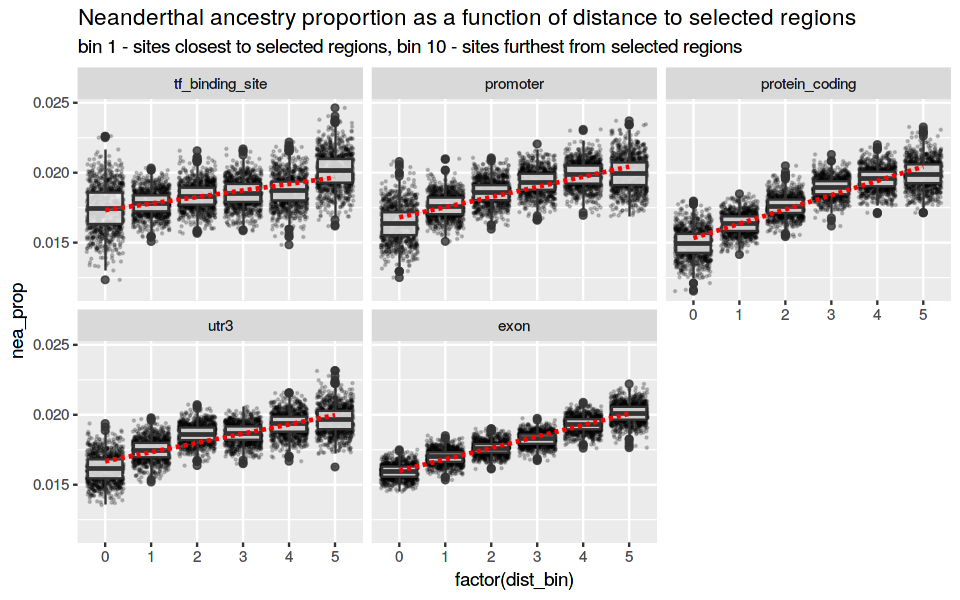

In [12]:
options(repr.plot.width = 8, repr.plot.height = 5)

bin_props %>%
    filter(gen == 2200) %>% 
    mutate(region = factor(region, levels = region_sizes$region)) %>% 
    ggplot(aes(factor(dist_bin), nea_prop)) +
        geom_jitter(alpha = 1/5, size = 0.2) +
        geom_boxplot(alpha = 0.8) +
        geom_smooth(aes(group = 1), method = "lm", linetype = 2, color = "red") +
        facet_wrap(~ region) +
        ggtitle("Neanderthal ancestry proportion as a function of distance to selected regions",
                "bin 1 - sites closest to selected regions, bin 10 - sites furthest from selected regions")

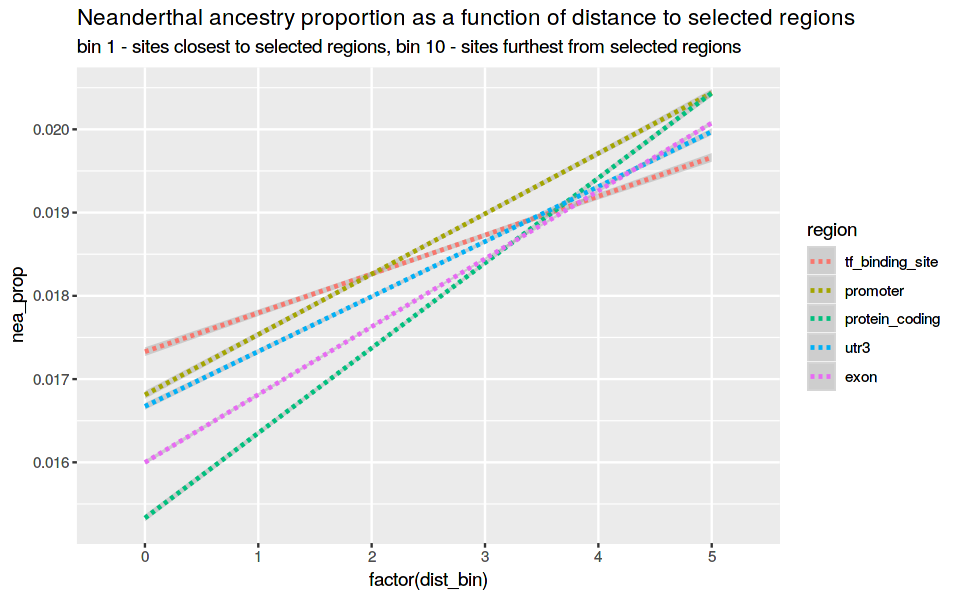

In [14]:
options(repr.plot.width = 8, repr.plot.height = 5)

bin_props %>%
    filter(gen == 2200) %>%
    mutate(region = factor(region, levels = region_sizes$region)) %>% 
    ggplot(aes(factor(dist_bin), nea_prop, color = region)) +
        geom_smooth(aes(group = region), method = "lm", linetype = 2) +
        ggtitle("Neanderthal ancestry proportion as a function of distance to selected regions",
                "bin 1 - sites closest to selected regions, bin 10 - sites furthest from selected regions")

# Testing scaling of s

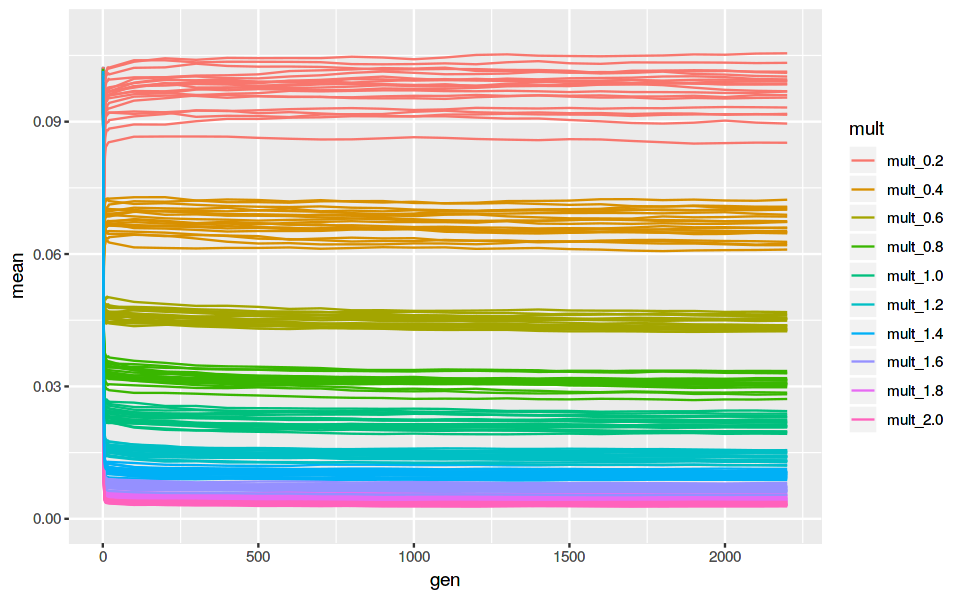

In [15]:
list.files("../data/simulations/", pattern="^delta_constant_exon_mult.*trajectory.*", full.names = T) %>%
map_dfr(~ suppressMessages(read_tsv(.x)) %>% mutate(mult = str_extract(.x, "mult_[0-2]\\.."), rep = runif(1))) %>%
ggplot(aes(gen, mean, group = rep, color = mult)) + geom_line() +
ylim(0, 0.11)

In [5]:
multipliers <- c("0.2", "0.4", "0.6", "0.8", "1.0", "1.2", "1.4", "1.6", "1.8", "2.0")

In [32]:
region <- "exon"

mult_bin_props <- map_dfr(multipliers,
                          function(mult) {

# load the table of coordinates (real and SLiM-based) of functional regions
regions <- read_coordinates(paste0("../data/slim_coords/", region, "_regions.bed"))
trans_regions <- transpose_coordinates(regions, regions)

# load the table of coordinates (real and SLiM-based) of fixed markers (both within and outside selected regions)
all_sites <- read_coordinates(paste0("../data/slim_coords/", region, "_all_sites.bed"))

binned_chroms <- mclapply(1:20, mc.cores = 20, function(rep) {

    path <- paste0("../data/simulations/delta_constant_", region, "_mult_", mult, "_h_0.5_rep_", rep, "_gen_", 2200, ".vcf.gz")

    if (!file.exists(path))
        return(NULL)

    vcf <- read_vcf(path)

    trans_markers <- mut_gt(vcf, mut_type = 1) %>% fill_lost(all_sites) %>% transpose_coordinates(all_sites)

    inside_markers  <- trans_markers[trans_markers %within% trans_regions]
    outside_markers <- trans_markers[! trans_markers %within% trans_regions]

    distance_hits <- distanceToNearest(outside_markers, trans_regions, ignore.strand = TRUE)
    qs <- quantile(mcols(distance_hits)$distance, probs = seq(0, 1, 1 / n_bins))

    outside_dist <- mcols(outside_markers) %>%
        as.data.frame %>%
        mutate(distance = mcols(distance_hits)$distance,
               dist_bin = as.integer(cut(distance, breaks = qs, labels = 1:n_bins, include.lowest = TRUE))) %>%
        mutate(rep = rep) %>%
        select(rep, freq, dist_bin, starts_with("chr"))

    inside_dist <- mcols(inside_markers) %>%
        as.data.frame %>%
        mutate(dist_bin = 0) %>%
        mutate(rep = rep) %>%
        select(rep, freq, dist_bin, starts_with("chr"))
    
    bind_rows(outside_dist, inside_dist)

}) %>% bind_rows

group_by(binned_chroms, dist_bin) %>%
    summarise_at(vars(starts_with("chr")), mean) %>%
    gather(chr, nea_prop, -dist_bin) %>%
    ungroup %>% 
    mutate(dist_bin = factor(dist_bin),
           mult = mult)

})

In [34]:
table(mult_bin_props$mult)


 0.2  0.4  0.6  0.8  1.0  1.2  1.4  1.6  1.8  2.0 
6000 6000 6000 6000 6000 6000 6000 6000 6000 6000 

Warning message:
“Removed 22153 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 22153 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 22153 rows containing missing values (geom_point).”Warning message:
“Removed 1 rows containing missing values (geom_smooth).”

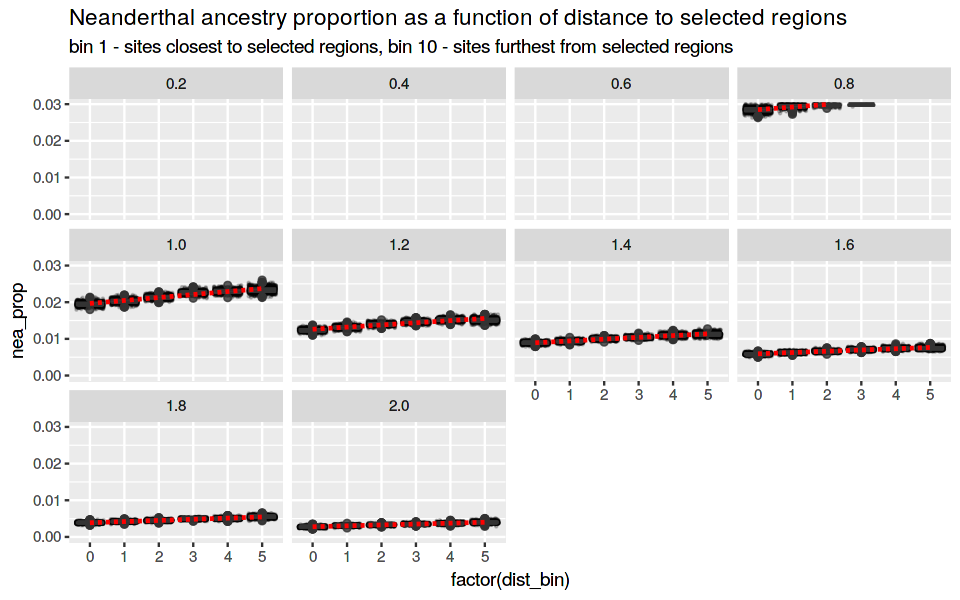

In [35]:
options(repr.plot.width = 8, repr.plot.height = 5)

mult_bin_props %>% 
    ggplot(aes(factor(dist_bin), nea_prop)) +
        geom_jitter(alpha = 1/5, size = 0.2) +
        geom_boxplot(alpha = 0.8) +
        geom_smooth(aes(group = 1), method = "lm", linetype = 2, color = "red") +
        facet_wrap(~ mult) + ylim(0, 0.03) +
        ggtitle("Neanderthal ancestry proportion as a function of distance to selected regions",
                "bin 1 - sites closest to selected regions, bin 10 - sites furthest from selected regions")

Normalize the proportions to have 2% in the highest bin:

In [36]:
(diffs <- filter(mult_bin_props, dist_bin == 5) %>% group_by(mult) %>% summarise(diff = mean(nea_prop) - 0.02))

mult,diff
0.2,0.077497418
0.4,0.047164124
0.6,0.026217115
0.8,0.012985121
1.0,0.003335348
1.2,-0.004860513
1.4,-0.008714414
1.6,-0.012491673
1.8,-0.014522912
2.0,-0.015989792


In [38]:
norm_mult_bin_props <- mult_bin_props

for (mult in multipliers) {
    norm_mult_bin_props[norm_mult_bin_props$mult == mult, "nea_prop"] <- norm_mult_bin_props[norm_mult_bin_props$mult == mult, ]$nea_prop - diffs[diffs$mult == mult, ]$diff
}

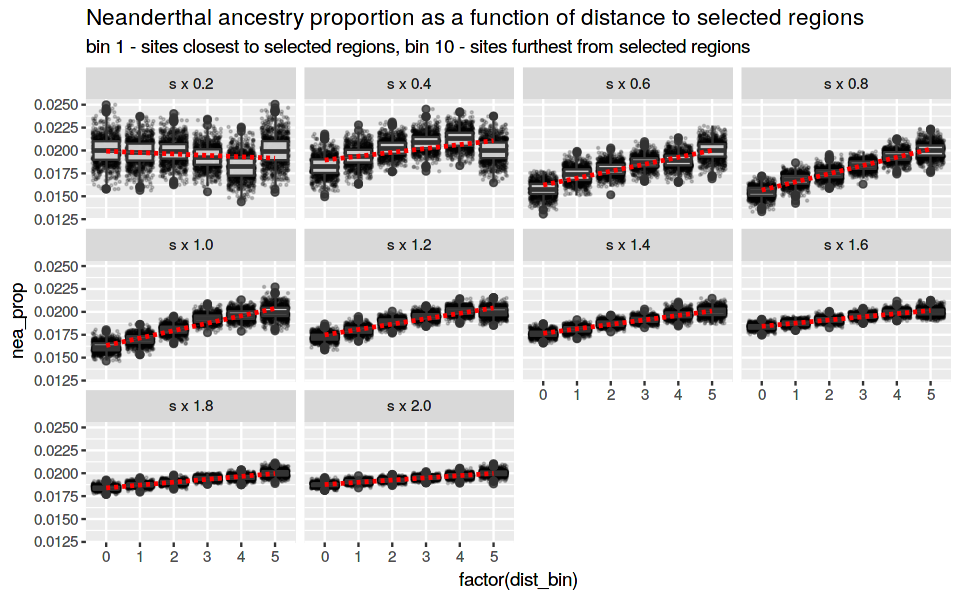

In [39]:
options(repr.plot.width = 8, repr.plot.height = 5)

norm_mult_bin_props %>% 
    mutate(mult = paste0("s x ", mult)) %>% 
    ggplot(aes(factor(dist_bin), nea_prop)) +
        geom_jitter(alpha = 1/5, size = 0.2) +
        geom_boxplot(alpha = 0.8) +
        geom_smooth(aes(group = 1), method = "lm", linetype = 2, color = "red") +
        facet_wrap(~ mult) +
        ggtitle("Neanderthal ancestry proportion as a function of distance to selected regions",
                "bin 1 - sites closest to selected regions, bin 10 - sites furthest from selected regions")

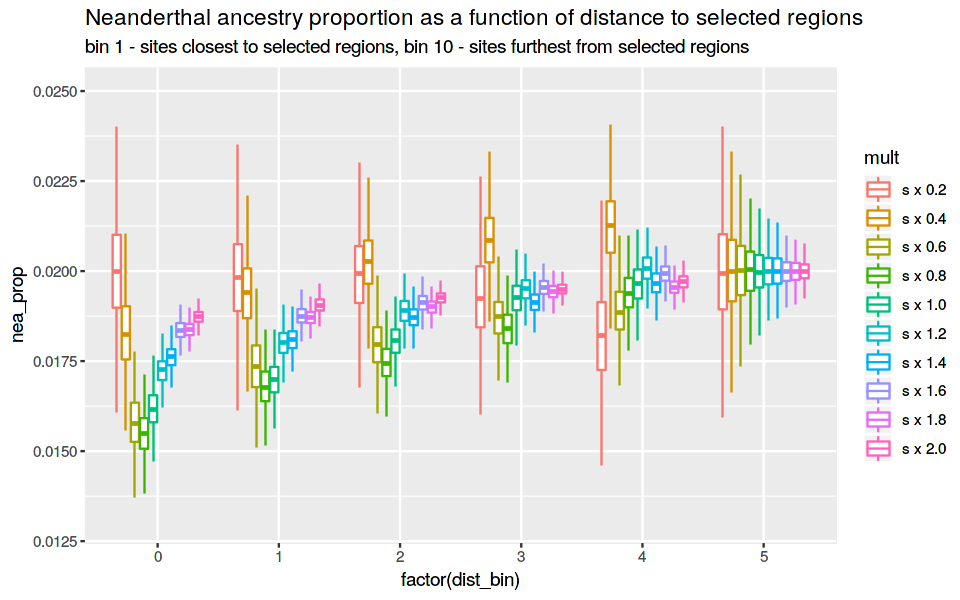

In [46]:
options(repr.plot.width = 8, repr.plot.height = 5)

norm_mult_bin_props %>%
    mutate(mult = paste0("s x ", mult)) %>% 
    ggplot(aes(factor(dist_bin), nea_prop, color = mult)) +
        geom_boxplot(outlier.shape = NA) +
        ggtitle("Neanderthal ancestry proportion as a function of distance to selected regions",
                "bin 1 - sites closest to selected regions, bin 10 - sites furthest from selected regions")

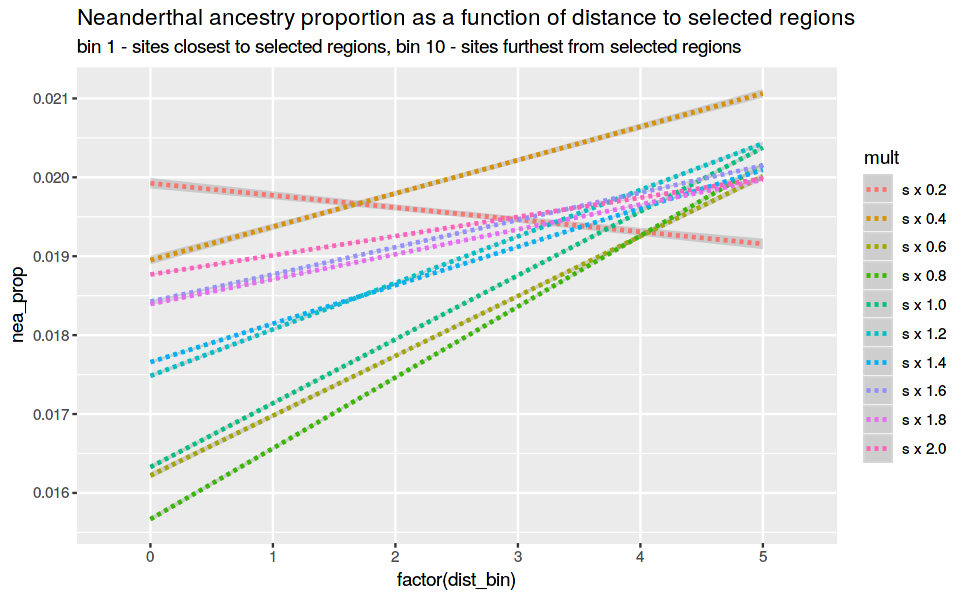

In [41]:
options(repr.plot.width = 8, repr.plot.height = 5)

norm_mult_bin_props %>%
    mutate(mult = paste0("s x ", mult)) %>% 
    ggplot(aes(factor(dist_bin), nea_prop, color = mult)) +
        geom_smooth(aes(group = mult), method = "lm", linetype = 2) +
        ggtitle("Neanderthal ancestry proportion as a function of distance to selected regions",
                "bin 1 - sites closest to selected regions, bin 10 - sites furthest from selected regions")

# Dominance

In [5]:
dominances <- c("0.0", "0.5", "1.0")

In [23]:
region <- "exon"

h_bin_props <- map_dfr(dominances,
                          function(h) {

# load the table of coordinates (real and SLiM-based) of functional regions
regions <- read_coordinates(paste0("../data/slim_coords/", region, "_regions.bed"))
trans_regions <- transpose_coordinates(regions, regions)

# load the table of coordinates (real and SLiM-based) of fixed markers (both within and outside selected regions)
all_sites <- read_coordinates(paste0("../data/slim_coords/", region, "_all_sites.bed"))

binned_chroms <- mclapply(1:20, mc.cores = 20, function(rep) {
    
map_dfr(gens, function(gen) {
    if (!file.exists(paste0("../data/simulations/delta_constant_", region, "_dom_h_", h, "_rep_", rep, "_gen_", gen, ".vcf.gz"))) {
        return(NULL)
    }
    vcf <- read_vcf(paste0("../data/simulations/delta_constant_", region, "_dom_h_", h, "_rep_", rep, "_gen_", gen, ".vcf.gz"))

    trans_markers <- mut_gt(vcf, mut_type = 1) %>% fill_lost(all_sites) %>% transpose_coordinates(all_sites)

    inside_markers  <- trans_markers[trans_markers %within% trans_regions]
    outside_markers <- trans_markers[! trans_markers %within% trans_regions]

    hap_ids <- colnames(mcols(inside_markers)) %>% keep(~ str_detect(.x, "chr"))

    distance_hits <- distanceToNearest(outside_markers, trans_regions, ignore.strand = TRUE)
    qs <- quantile(mcols(distance_hits)$distance, probs = seq(0, 1, 1 / n_bins))

    outside_dist <- mcols(outside_markers) %>%
        as.data.frame %>%
        mutate(distance = mcols(distance_hits)$distance,
               dist_bin = as.integer(cut(distance, breaks = qs, labels = 1:n_bins, include.lowest = TRUE))) %>%
        mutate(rep = rep, gen = gen) %>%
        select(rep, gen, freq, dist_bin, starts_with("chr"))

    inside_dist <- mcols(inside_markers) %>%
        as.data.frame %>%
        mutate(dist_bin = 0) %>%
        mutate(rep = rep, gen = gen) %>%
        select(rep, gen, freq, dist_bin, starts_with("chr"))
    
    bind_rows(outside_dist, inside_dist)

})

}) %>% bind_rows

group_by(binned_chroms, dist_bin, gen) %>%
    summarise_at(vars(starts_with("chr")), mean) %>%
    gather(chr, nea_prop, -dist_bin, -gen) %>%
    ungroup %>% 
    mutate(dist_bin = factor(dist_bin),
           h = h)

})

In [24]:
table(h_bin_props$h)


  0.0   0.5   1.0 
90000 90000 90000 

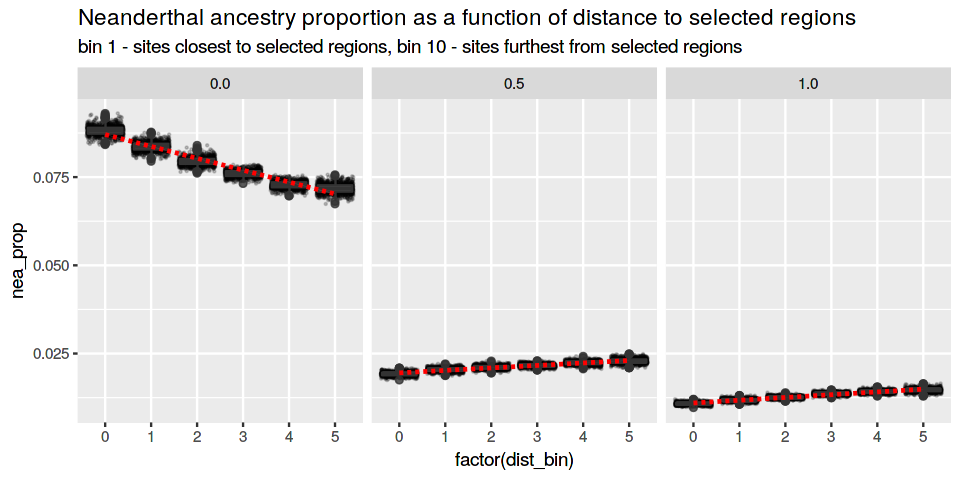

In [28]:
options(repr.plot.width = 8, repr.plot.height = 4)

h_bin_props %>% 
    filter(gen == 2200) %>% 
    ggplot(aes(factor(dist_bin), nea_prop)) +
        geom_jitter(alpha = 1/5, size = 0.2) +
        geom_boxplot(alpha = 0.8) +
        geom_smooth(aes(group = 1), method = "lm", linetype = 2, color = "red") +
        facet_wrap(~ h) +
        ggtitle("Neanderthal ancestry proportion as a function of distance to selected regions",
                "bin 1 - sites closest to selected regions, bin 10 - sites furthest from selected regions")

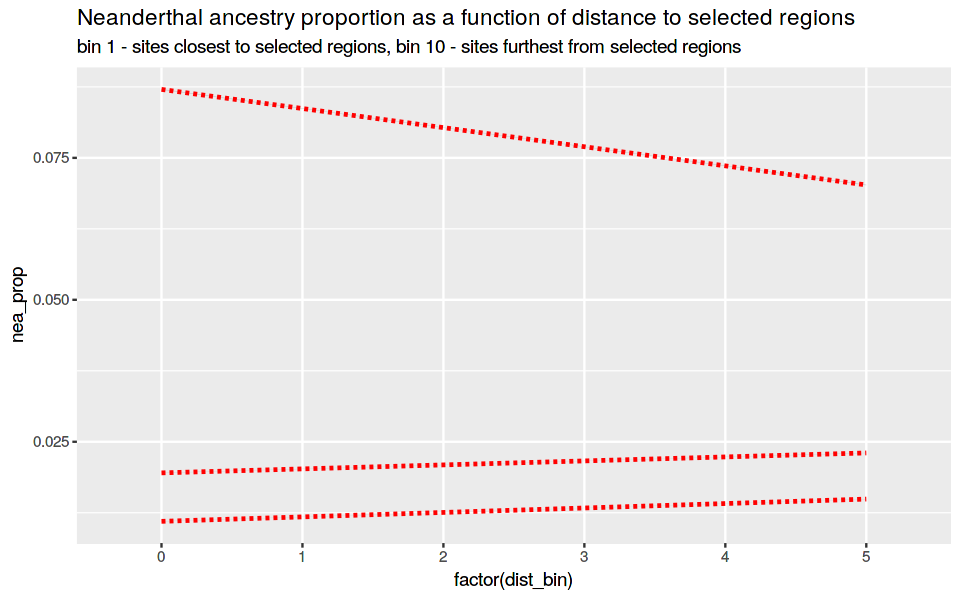

In [31]:
options(repr.plot.width = 8, repr.plot.height = 5)

h_bin_props %>% 
    filter(gen == 2200) %>% 
    ggplot(aes(factor(dist_bin), nea_prop)) +
        geom_smooth(aes(group = h), method = "lm", linetype = 2, color = "red") +
        ggtitle("Neanderthal ancestry proportion as a function of distance to selected regions",
                "bin 1 - sites closest to selected regions, bin 10 - sites furthest from selected regions")